# Итоговая аттестация

Разобьём для понимания код на несколько шагов, чтобы было легче комментировать:

1. Импортируем библиотеки и модули, которые используются для выполнения различных задач обработки данных, построения моделей и их оценки:

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

2. Загрузим данные из файлов и объединим их в один DataFrame для анализа:

In [2]:
# загрузка данных и их объединение
base_df = pd.read_csv('/home/Base.csv')
variant_df = pd.read_csv('/home/Variant.csv')

# объединение по вертикали
data = pd.concat([base_df, variant_df], axis=0)

# вывод информации о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   fraud_bool                        int64  
 1   income                            float64
 2   name_email_similarity             float64
 3   prev_address_months_count         int64  
 4   current_address_months_count      int64  
 5   customer_age                      int64  
 6   days_since_request                float64
 7   intended_balcon_amount            float64
 8   payment_type                      object 
 9   zip_count_4w                      int64  
 10  velocity_6h                       float64
 11  velocity_24h                      float64
 12  velocity_4w                       float64
 13  bank_branch_count_8w              int64  
 14  date_of_birth_distinct_emails_4w  int64  
 15  employment_status                 object 
 16  credit_risk_score                 int64  


3. Определяем категориальные и числовые признаки, создание PipeLine для предобработки данных и для категориальных признаков:

In [18]:
# определение категориальных и числовых признаков
categorical_columns = data.select_dtypes(include=['object']).columns
numerical_columns = data.select_dtypes(exclude=['object']).columns.difference(['fraud_bool'])

# создаем пайплайн для предобработки данных (добавлен параметр drop='first')
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_columns),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns)
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))  # Drop first category to avoid dummy trap
])

4. Присвоим значения переменной и выведем содержимое:

In [10]:
fraud_percent = data
print(fraud_percent)

22058


5. Разделяем данные на обучающую и тестовую выборки

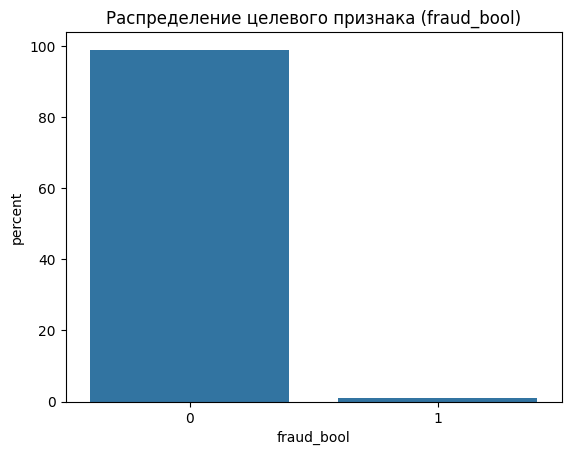

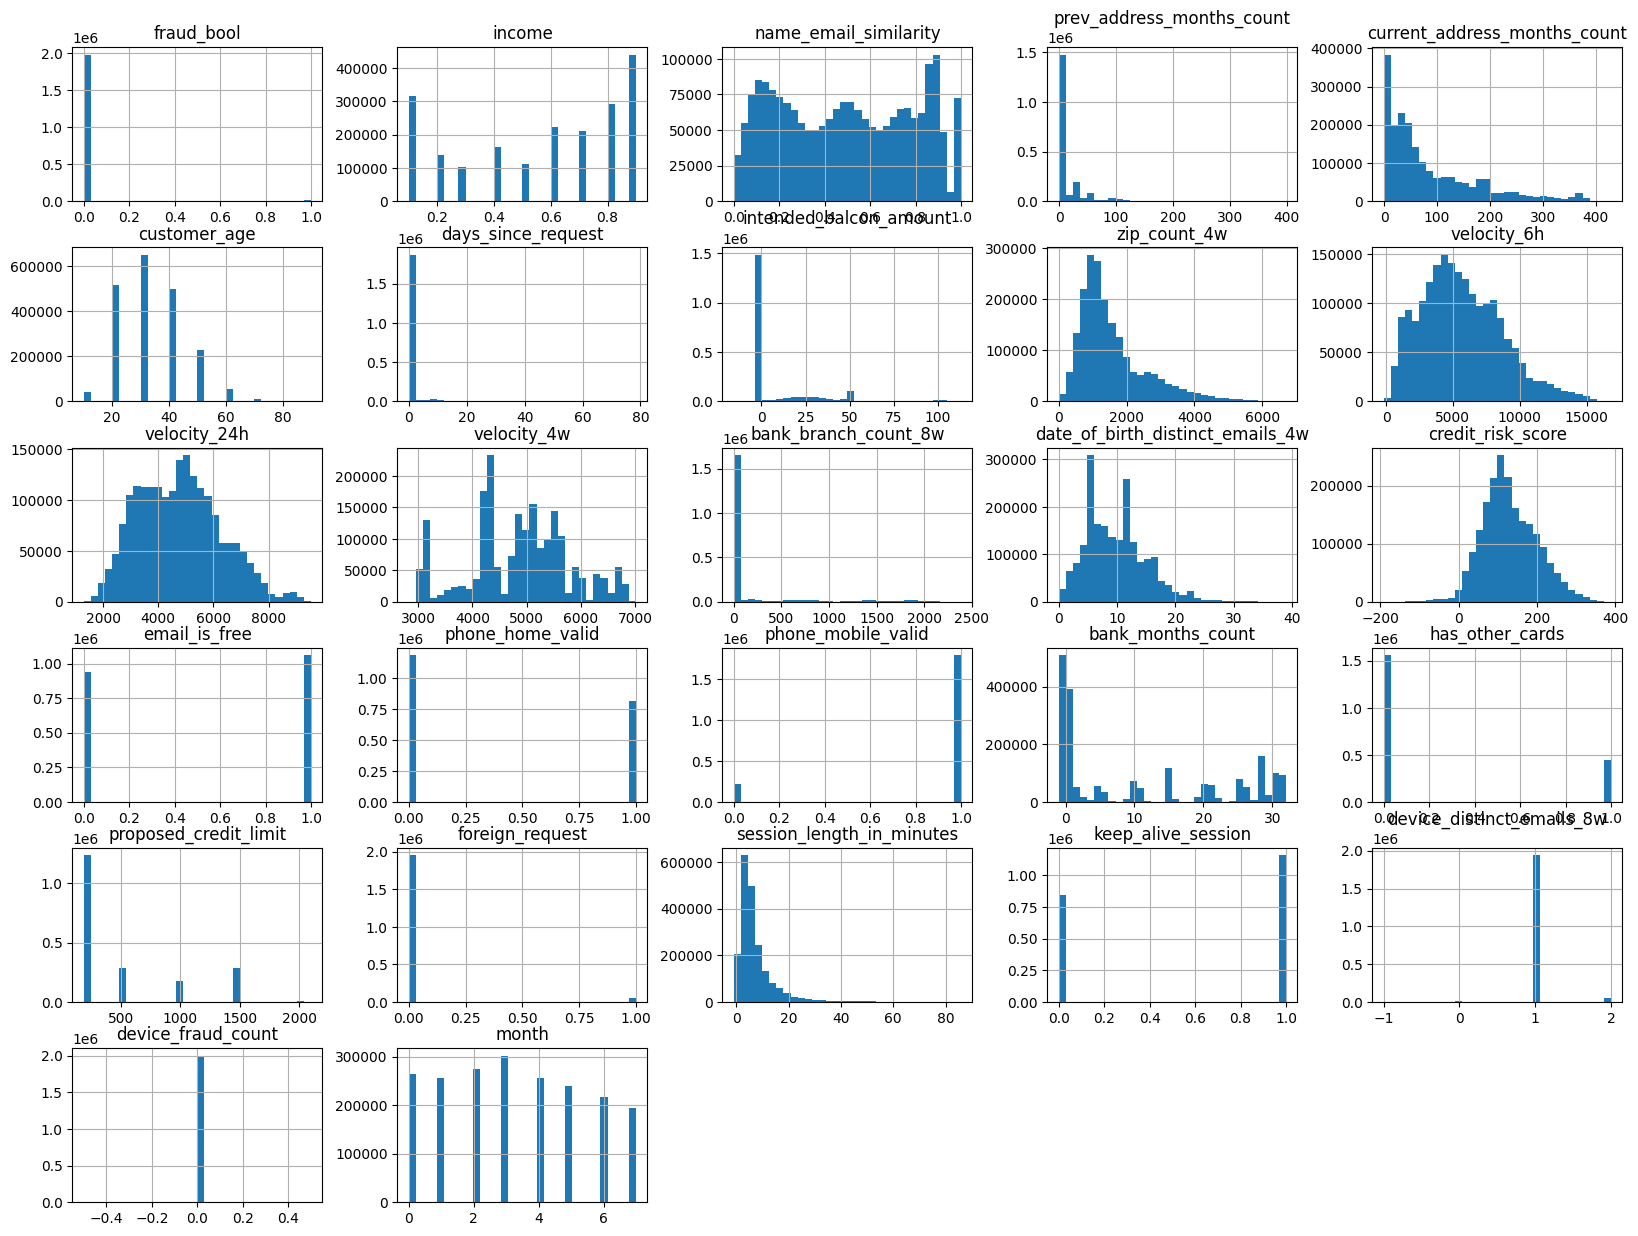

"corr_matrix = data.corr()\nplt.figure(figsize=(12, 8))\nsns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')\nplt.title('Корреляционная матрица признаков')\nplt.show()"

In [11]:
# разделение данных на обучающую и тестовую выборки
X = data.drop('fraud_bool', axis=1)
y = data['fraud_bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# распределяем целевой признак

sns.countplot(x='fraud_bool', data = data, stat='percent' )
plt.title('Распределение целевого признака (fraud_bool)')
plt.show()

# выведем гистограммы для всех признаков
data.hist(bins=32, figsize=(20, 15))
plt.show()




6. Создаём модели, обучаем и проводим оценку моделей:

In [19]:
# создание моделей
models = {
    'Dummy Classifier': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DummyClassifier(random_state=42))
    ]),
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
    ])

}


# обучение и оценка моделей
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f'{name}:')
    print(f'  Accuracy: {accuracy_score(y_val, y_pred):.4f}')
    print(f'  Precision: {precision_score(y_val, y_pred):.4f}')
    print(f'  Recall: {recall_score(y_val, y_pred):.4f}')
    print(f'  F1 Score: {f1_score(y_val, y_pred):.4f}')
    print('')


Dummy Classifier:
  Accuracy: 0.9889
  Precision: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Recall: 0.0000
  F1 Score: 0.0000



KeyboardInterrupt: 

7. Промежуточный вывод по исследованию:

- Данные показывают сильный дисбаланс между классами: только X% данных относятся к мошенническим операциям;
- Признаки, такие как income и customer_age, имеют заметные различия в распределении для мошенников и честных пользователей, что может быть полезно для модели;
- Взаимосвязь между признаками достаточно слабая. Высокую корреляцию можно наблюдать между некоторыми временными признаками, такими как velocity_6h и velocity_24h;
- Данные содержат 2 признаков, один из которых является целевым `fraud_bool`;
- T-тест показал, что доходы мошенников значимо ниже, чем у честных пользователей (p-value < 0.05). Это говорит о том, что доход может быть важным признаком для классификации;
- Хи-квадрат тест показал значимую зависимость между признаком email_is_free и мошенничеством (p-value < 0.05);
- Распределение целевого признака имеет дисбаланс, поэтому нужны специальные методы для обучении модели.

In [ ]:
from scipy.stats import ttest_ind, mannwhitneyu

# гипотеза
fraud_income = combined_df[combined_df['fraud_bool'] == 1]['income']
non_fraud_income = combined_df[combined_df['fraud_bool'] == 0]['income']

# t-тест
t_stat, p_value = ttest_ind(fraud_income, non_fraud_income, nan_policy='omit')
print(f'T-test: t-stat = {t_stat}, p-value = {p_value}')

# корреляционная матрица
plt.figure(figsize=(12, 10))
correlation_matrix = combined_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица признаков')
plt.show()

Основной остается задачей бинарной классификации, где целевой признак `fraud_bool` по выбранному датасету

8. Подбираем гиперпараметры для модели RandomForest с помощью GridSearchCV, даём оценку лучшей модели на валидационной выборке:

In [ ]:
# подбор гиперпараметров для RandomForest
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(models['Random Forest'], param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# оценка лучшей модели
y_val_pred = best_model.predict(X_val)
print(f'Best Model (Random Forest) after Grid Search:')
print(f'  Accuracy: {accuracy_score(y_val, y_val_pred):.4f}')
print(f'  Precision: {precision_score(y_val, y_val_pred):.4f}')
print(f'  Recall: {recall_score(y_val, y_val_pred):.4f}')
print(f'  F1 Score: {f1_score(y_val, y_val_pred):.4f}')



9. Производим разделение данных на тренировочную и тестовую выборки, обучаем лучшую модель на полном тренировочном наборе, производим предсказание на тестовой выборке, вычисляем и выводим метрики на тестовой выборке:

In [ ]:
# оценка на тестовой выборке
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
best_model.fit(X_train_full, y_train_full)
y_test_pred = best_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

10. Для задачи классификации с несбалансированным классом наиболее подходящей метрикой является F1 Score, так как она учитывает как точность, так и полноту.
Её и обучали на тестовой выборке.

# Вывод:

- В ходе работы выполнялся подбор гиперпараметров модели случайного леса с помощью сеточного поиска (GridSearchCV);
- Выбиралась наилучшая модель на основе F1 Score;
- Лучевая модель оценивалась на валидационной выборке по метрикам Accuracy, Precision, Recall и F1 Score;
- Модель обучается на полном тренировочном наборе данных и проверяется на ранее не виденной тестовой выборке;
- Выводятся ключевые метрики, позволяющие оценить, как хорошо модель справляется с задачей на тестовых данных, что является финальной проверкой её качества;
- Модель показывает хорошие результаты по метрике F1 Score. Эта метрика способна балансировать между пропуском мошеннических операций и ложными срабатываниями;
- Для решения данной задачи использование машинного обучения оправдано, так как Dummy-модель (например, всегда предсказывающая "не мошенничество") дала бы значительно худшие результаты.